In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

### 1. Load conceptual geomodels

In [2]:
# Loading all conceptual geomodels contained in the int8 format file
# In geomodels:  0-background mud faceis, 1-channel facies, 2-lobe facies
dirpath = '/scratch/users/suihong/SubwaterFan/LargeConceptualModelsfromPetrel/' 

rlz_no = 400
con_x_size = 400
con_y_size = 400
con_z_size = 50

concpts = np.load(dirpath + 'concpts_all_int8.txt.npy')
print(concpts.shape)

concpts = concpts.transpose(1,0).reshape(rlz_no, con_x_size, con_y_size, con_z_size)
print(concpts.shape)

(8000000, 400)
(400, 400, 400, 50)


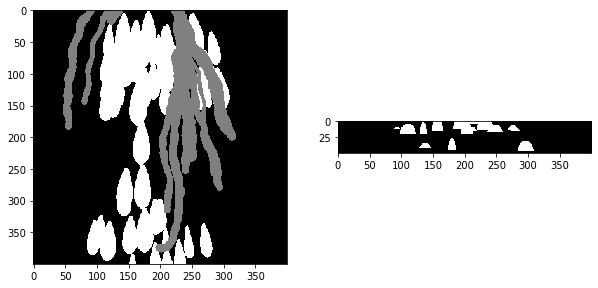

In [3]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5, forward=True)
ax[0].imshow(concpts[1, :, :, 0], cmap='gray')
ax[1].imshow(concpts[1,-1,:,:].transpose(1,0), cmap='gray')

### 2. Crop training geomodels

In [6]:
def rand_crop(faciesmodel, crop_num, crop_x_size, crop_y_size, crop_z_size):
    sand_indices = np.argwhere(faciesmodel > 0.9)
    crop_indices = np.random.randint(0, sand_indices.shape[0], crop_num)
    crop_pt_coos = sand_indices[crop_indices]
    [model_x_size, model_y_size, model_z_size] = faciesmodel.shape

    facies_crops = np.zeros((crop_num, crop_x, crop_y, crop_z), np.int8)    
    
    for k in range(crop_num):
        [pt_x, pt_y, pt_z] = crop_pt_coos[k]
        
        x_e_dist = model_x_size - 1 - pt_x  # distance between sampled point to the east boundary
        y_s_dist = model_y_size - 1 - pt_y
        z_b_dist = model_z_size - 1 - pt_z
        
        if x_e_dist <= crop_x_size - 1:
            dx_e = np.random.randint(0, x_e_dist + 1)
            crop_x_ed = pt_x + dx_e
            crop_x_st = crop_x_ed - crop_x_size
        else:
            crop_x_st = max(0, pt_x - np.random.randint(0, crop_x_size - 1))
            crop_x_ed = crop_x_st + crop_x_size
            
        if y_s_dist <= crop_y_size - 1:
            dy_s = np.random.randint(0, y_s_dist)
            crop_y_ed = pt_y + dy_s
            crop_y_st = crop_y_ed - crop_y_size
        else:
            crop_y_st = max(0, pt_y - np.random.randint(0, crop_y_size - 1))
            crop_y_ed = crop_y_st + crop_y_size   


        if model_z_size >= 2 * crop_z_size:            
            if pt_z <= crop_z_size:
                crop_z_st = np.random.randint(0, pt_z + 1)
                crop_z_ed = crop_z_st + crop_z_size               
            elif pt_z <= model_z_size - crop_z_size:
                crop_z_st = np.random.randint(pt_z - crop_z_size, pt_z + 1)
                crop_z_ed = crop_z_st + crop_z_size                 
            else:
                crop_z_ed = np.random.randint(pt_z, model_z_size)
                crop_z_st = crop_z_ed - crop_z_size
        else:
            if pt_z <= model_z_size - crop_z_size:
                crop_z_st = np.random.randint(0, pt_z + 1)
                crop_z_ed = crop_z_st + crop_z_size               
            elif pt_z <= crop_z_size:
                crop_z_st = np.random.randint(0, model_z_size - crop_z_size + 1)
                crop_z_ed = crop_z_st + crop_z_size                 
            else:
                crop_z_ed = np.random.randint(pt_z, model_z_size)
                crop_z_st = crop_z_ed - crop_z_size            

        facies_crops[k] = faciesmodel[crop_x_st: crop_x_ed, crop_y_st: crop_y_ed, crop_z_st: crop_z_ed]    
        
    return facies_crops

In [7]:
crops_for_each_model = 24
crop_x, crop_y, crop_z = 128, 128, 32
facies_crops = np.zeros((rlz_no, crops_for_each_model, crop_x, crop_y, crop_z))

for i in range(rlz_no):
    facies_model_i = concpts[i]   # shape of [400, 400, 400]
    facies_crops[i] = rand_crop(facies_model_i, crops_for_each_model, crop_x, crop_y, crop_z)
    
    print(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

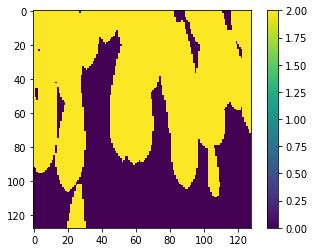

In [8]:
plt.imshow(facies_crops[26,22,:,:,15])
plt.colorbar()

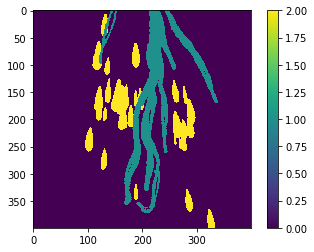

In [9]:
plt.imshow(concpts[0,:,:,25])
plt.colorbar()

In [10]:

facies_crops = facies_crops.reshape(-1, 1, 128, 128, 32)
# randomly permute facies_crops:
random_seq=np.random.RandomState(232).permutation(facies_crops.shape[0])
facies_crops = facies_crops[random_seq]

### 3 Downsample and save training and test datasets

In [14]:
# dirpath = '/scratch/users/suihong/SubwaterFan/LargeConceptualModelsfromPetrel/'

tfrecord_dir_training = '/scratch/users/suihong/SubwaterFan/dataset_test/TrainingData'
tfrecord_dir_test = '/scratch/users/suihong/SubwaterFan/dataset_test/TestData'

In [11]:
# split facies models into training and test dataset
#randseq=np.random.RandomState(232).permutation(allcubes.shape[0])
facies_crops_training = facies_crops[:9000]
facies_crops_test = facies_crops[9000:]
print(facies_crops_training.shape)
print(facies_crops_test.shape)

(9000, 1, 128, 128, 32)
(600, 1, 128, 128, 32)


#### Store training dataset

In [12]:
import tensorflow.compat.v1 as tf

In [15]:
from scipy import stats
# copy from ProGAN github dataset_tools.py
class TFRecordExporter:
    def __init__(self, tfrecord_dir, expected_cubes, print_progress=True, progress_interval=10):
        self.tfrecord_dir       = tfrecord_dir
        self.tfr_prefix         = os.path.join(self.tfrecord_dir, os.path.basename(self.tfrecord_dir))
        self.expected_cubes    = expected_cubes
        self.cur_cubes         = 0
        self.shape              = None
        self.max_res_log2      = None
        self.tfr_writers        = []
        self.print_progress     = print_progress
        self.progress_interval  = progress_interval
        if self.print_progress:
            print('Creating dataset "%s"' % tfrecord_dir)
        if not os.path.isdir(self.tfrecord_dir):
            os.makedirs(self.tfrecord_dir)
        assert(os.path.isdir(self.tfrecord_dir))
        
    def close(self):
        if self.print_progress:
            print('%-40s\r' % 'Flushing data...', end='', flush=True)
        for tfr_writer in self.tfr_writers:
            tfr_writer.close()
        self.tfr_writers = []
        if self.print_progress:
            print('%-40s\r' % '', end='', flush=True)
            print('Added %d cubes.' % self.cur_cubes)

    def choose_shuffled_order(self): # Note: Cubes and labels must be added in shuffled order.
        order = np.arange(self.expected_cubes)
        np.random.RandomState(123).shuffle(order)
        return order

                
    def add_real_cube(self, real_cube):
        def downscale_factor(cube):
            cube_dim = cube.shape[1:]
            cube_dim_log2 = np.log2(cube_dim).astype(int)
            cube_dim_log2_dist = cube_dim_log2 - np.array([2, 2, 2])
            down_factor = np.where(cube_dim_log2_dist > 0, 2, 1)
            return down_factor
    
        if self.print_progress and self.cur_cubes % self.progress_interval == 0:
            print('%d / %d\r' % (self.cur_cubes, self.expected_cubes), end='', flush=True)
        if self.shape is None:
            self.shape = real_cube.shape   # [1, 64, 64, 64]
            self.max_res_log2  = max(np.log2(self.shape[1:]).astype(int))  # 6
            tfr_opt = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.NONE)
            for lod in range(self.max_res_log2 - 1):
                tfr_file = self.tfr_prefix + '-1r%02d.tfrecords' % (self.max_res_log2 - lod)
                self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
            self.tfr_writers.append(tf.python_io.TFRecordWriter(tfr_file, tfr_opt))
        assert real_cube.shape == self.shape
        
        for lod, tfr_writer in enumerate(self.tfr_writers[:-1]):
            if lod:
                real_cube = real_cube.astype(np.float32)
                # used to produce low-D with averaging method                
                dwscl_factor = downscale_factor(real_cube)
                fac_x, fac_y, fac_z = dwscl_factor                
                
                # have problem if fac_z = 1
                #real_cube = (real_cube[:, 0::fac_x, 0::fac_y, 0::fac_z] + real_cube[:, 0::fac_x, fac_y - 1::fac_y, 0::fac_z] + \
                #             real_cube[:, fac_x - 1::fac_x, 0::fac_y, 0::fac_z] +real_cube[:, fac_x - 1::fac_x, fac_y - 1::fac_y, 0::fac_z] + \
                #             real_cube[:, 0::fac_x, 0::fac_y, fac_z - 1::fac_z] + real_cube[:, 0::fac_x, fac_y - 1::fac_y, fac_z - 1::fac_z] + \
                #             real_cube[:, fac_x - 1::fac_x, 0::fac_y, fac_z - 1::fac_z] + \
                #             real_cube[:, fac_x - 1::fac_x, fac_y - 1::fac_y, fac_z - 1::fac_z])/ (fac_x * fac_y * fac_z)



                # used to produce low-D with method （once channel exist, it remain channel; otherwise, keep lobes if lobes exist）
                # facies remain order: channel (code 1), lobes (code 2), mud (code 0)
                # convert code 1 into 9 for channels, for easy frequency computation. Remember to convert back finally.
                real_cube = np.where(real_cube == 1, 9, real_cube)
                real_cube = np.expand_dims(real_cube, axis = -1)    
                # Mind where fac_z = 1
                real_cube = np.concatenate((real_cube[:, 0::fac_x, 0::fac_y, 0::fac_z], real_cube[:, 0::fac_x, fac_y - 1::fac_y, 0::fac_z], \
                                            real_cube[:, fac_x - 1::fac_x, 0::fac_y, 0::fac_z], real_cube[:, fac_x - 1::fac_x, fac_y - 1::fac_y, 0::fac_z], \
                                            real_cube[:, 0::fac_x, 0::fac_y, fac_z - 1::fac_z], real_cube[:, 0::fac_x, fac_y - 1::fac_y, fac_z - 1::fac_z], \
                                            real_cube[:, fac_x - 1::fac_x, 0::fac_y, fac_z - 1::fac_z], \
                                            real_cube[:, fac_x - 1::fac_x, fac_y - 1::fac_y, fac_z - 1::fac_z]), axis = -1)
                real_cube = np.max(real_cube, axis = -1)
                real_cube = np.where(real_cube == 9, 1, real_cube)             

                
            quant = np.rint(real_cube).clip(0, 2).astype(np.uint8)
            ex = tf.train.Example(features=tf.train.Features(feature={
                'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
                'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
            tfr_writer.write(ex.SerializeToString())
        self.cur_cubes += 1            
            
    def __enter__(self):
        return self
    
    def __exit__(self, *args):
        self.close()

In [16]:
with TFRecordExporter(tfrecord_dir_training, facies_crops_training.shape[0]) as tfr:
    order = tfr.choose_shuffled_order()
    for idx in range(order.size):
        tfr.add_real_cube(facies_crops_training[order[idx]])      

Creating dataset "/scratch/users/suihong/SubwaterFan/dataset_test/TrainingData"


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Added 9000 cubes.                       


#### Store test dataset

In [17]:
with TFRecordExporter(tfrecord_dir_test, facies_crops_test.shape[0]) as tfr:
    for idx in range(facies_crops_test.shape[0]):
        tfr.add_real_cube(facies_crops_test[idx])      

Creating dataset "/scratch/users/suihong/SubwaterFan/dataset_test/TestData"


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Added 600 cubes.                        


### Facies-order based downsampling method illustration

#### Facies priority: channel > lobe > mud

In [18]:
def downscale_factor(cube):
    cube_dim = cube.shape[1:]
    cube_dim_log2 = np.log2(cube_dim).astype(int)
    cube_dim_log2_dist = cube_dim_log2 - np.array([2, 2, 2])
    down_factor = np.where(cube_dim_log2_dist > 0, 2, 1)
    return down_factor

def downsc_with_freq(cube):
    # convert code 1 into 9 for channels, for easy frequency computation. Remember to convert back finally.
    cube = np.where(cube == 1, 9, cube)
    
    cube = np.squeeze(cube, axis = 1)
    fac_x, fac_y, fac_z = downscale_factor(cube)
    cube = np.expand_dims(cube, axis = -1)
    
    # Mind where fac_z = 1
    ds_cube = np.concatenate((cube[:, 0::fac_x, 0::fac_y, 0::fac_z], cube[:, 0::fac_x, fac_y - 1::fac_y, 0::fac_z], \
                           cube[:, fac_x - 1::fac_x, 0::fac_y, 0::fac_z], cube[:, fac_x - 1::fac_x, fac_y - 1::fac_y, 0::fac_z], \
                           cube[:, 0::fac_x, 0::fac_y, fac_z - 1::fac_z], cube[:, 0::fac_x, fac_y - 1::fac_y, fac_z - 1::fac_z], \
                           cube[:, fac_x - 1::fac_x, 0::fac_y, fac_z - 1::fac_z], \
                           cube[:, fac_x - 1::fac_x, fac_y - 1::fac_y, fac_z - 1::fac_z]), axis = -1)
    ds_cube = np.max(ds_cube, axis = -1)
    ds_cube = np.expand_dims(ds_cube, axis = 1)
    ds_cube = np.where(ds_cube == 9, 1, ds_cube)
    return ds_cube

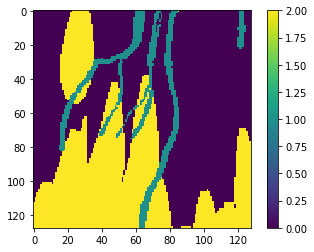

In [19]:
plt.imshow(facies_crops[124, 0, :, :, 16])
plt.colorbar()

In [20]:
facies_crops_64 = downsc_with_freq(facies_crops)
print(facies_crops_64.shape)

(9600, 1, 64, 64, 16)


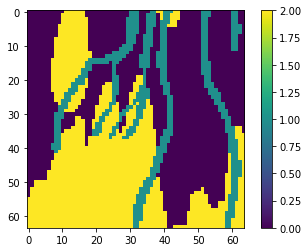

In [21]:
plt.imshow(facies_crops_64[124, 0, :, :, 8])
plt.colorbar()

In [22]:
facies_crops_32 = downsc_with_freq(facies_crops_64)
print(facies_crops_32.shape)

(9600, 1, 32, 32, 8)


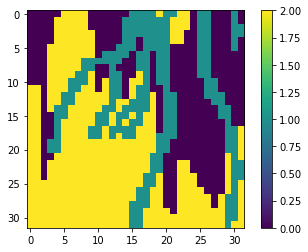

In [23]:
plt.imshow(facies_crops_32[124, 0, :, :, 4])
plt.colorbar()

In [24]:
facies_crops_16 = downsc_with_freq(facies_crops_32)
print(facies_crops_16.shape)

(9600, 1, 16, 16, 4)


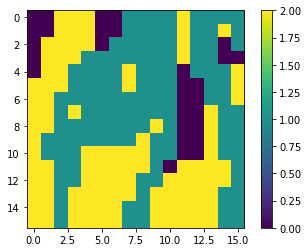

In [25]:
plt.imshow(facies_crops_16[124, 0, :, :, 2])
plt.colorbar()

In [26]:
facies_crops_8 = downsc_with_freq(facies_crops_16)
print(facies_crops_8.shape)

(9600, 1, 8, 8, 4)


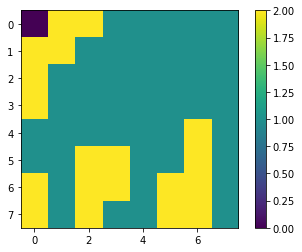

In [27]:
plt.imshow(facies_crops_8[124, 0, :, :, 2])
plt.colorbar()

In [28]:
facies_crops_4 = downsc_with_freq(facies_crops_8)
print(facies_crops_4.shape)

(9600, 1, 4, 4, 4)


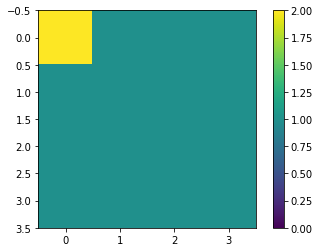

In [29]:
plt.imshow(facies_crops_4[124, 0, :, :, 2], vmax = 2, vmin = 0)
plt.colorbar()